Установка: https://pytorch.org/get-started/locally/

## Сравнение NumPy и PyTorch

Принципы работы в PyTorch немногим отличаются от операций с массивами в NumPy. Рассмотрим следующую функцию ошибки:

$$L=\| y - X\cdot \Theta\|^2_2+\lambda \|\Theta\|_1.$$

Данную функцию можно последовательно реализовать средствами NumPy:

In [1]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
y = np.random.randn(2, 1)
X = np.random.randn(2, 5)
theta = np.random.randn(5, 1)
lmbda = 0.1

pred = X.dot(theta)
pred_loss = np.sum((y - pred) ** 2)
reg_loss = lmbda * np.sum(np.abs(theta))
loss = pred_loss + reg_loss
print(loss)

18.50572269201279


На PyTorch реализация вычисления функции $L$ выглядит аналогично, однако вместо массивов NumPy используются специальные объекты &ndash; `torch.Tensor`. Создать тензор в PyTorch можно как из простого массива, так и из массива Numpy, при этом указав тип данных, содержащихся в тензоре (по умолчанию float32).

Подробнее о типах данных в PyTorch: https://pytorch.org/docs/stable/tensors.html

In [3]:
import torch

In [4]:
y = torch.Tensor(y)
X = torch.Tensor(X)
theta = torch.Tensor(theta).requires_grad_(True) # для theta понадобится вычислить градиент

pred = X.matmul(theta)
pred_loss = torch.sum((y - pred) ** 2)
reg_loss = lmbda * torch.sum(torch.abs(theta))
loss = pred_loss + reg_loss
print(loss)

tensor(18.5057, grad_fn=<AddBackward0>)


In [5]:
print(torch.Tensor([1, 2, 3]).type())
print(torch.Tensor(np.array([1, 2, 3])).type())
print(torch.LongTensor([1, 2, 3]).type())
print(torch.zeros([2, 2, 3], dtype=torch.int64).type())

print(torch.Tensor([[[1, 2, 3], [4, 5, 6]],[[7, 8, 9],[10, 11, 12]]]).size())

torch.FloatTensor
torch.FloatTensor
torch.LongTensor
torch.LongTensor
torch.Size([2, 2, 3])


## Обучение моделей градиентными методами

Обучение моделей в PyTorch производится в цикле. Ниже приведена реализация метода градиентного спуска. Чтобы обучать модели градиентными методами необходимо помнить о том, что на каждой итерации необходимо "обнулять градиенты" (в примере ниже `theta.grad.zero_()`), поскольку по умолчанию PyTorch накапливает градиент, а не вычисляет его заново для текущих значений параметров.

In [6]:
for i in range(10):
    pred = X.matmul(theta)
    pred_loss = torch.sum((y - pred) ** 2)
    reg_loss = lmbda * torch.sum(torch.abs(theta))
    loss = pred_loss + reg_loss

    loss.backward() # вычисляет градиент функции по указанным переменным при их текущих значениях
    theta.data.add_(-0.1*theta.grad.data)
    theta.grad.zero_()

Нижнее подчеркивание у функций перезаписывает значения переменных:

In [7]:
a = torch.Tensor([50, 45, 8])
b = 5

print(a.add(b))
print(a)
print(a.add_(b))
print(a)

tensor([55., 50., 13.])
tensor([50., 45.,  8.])
tensor([55., 50., 13.])
tensor([55., 50., 13.])


## Формирование архитектуры нейронной сети

### Бинарная классификация

В случае бинарной классификации в качестве функции потерь используется, как правило, бинарная кросс-энтропия. Она реализована в PyTorch в виде двух функций: `BCELoss` и `BCEWithLogitsLoss`.

Отличие данных функций состоит в том, что `BCELoss` вычисляет величину ошибки от выхода сети и требует, чтобы в архитектуре явно была указана функция активации на выходном слое. Функция `BCEWithLogitsLoss`, прежде чем вычислять величину потерь, применяет функцию активации (логистическую сигмоиду) к последнему слою, поэтому в архитектуре задавать функцию активации не нужно.

In [8]:
X = torch.FloatTensor(np.random.randn(5, 3))
y = torch.FloatTensor(np.random.randint(0, 2, 5)) # float32

#### Архитектура с `BCELoss`

In [9]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid() # явно задана функция активации
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.BCELoss()

for i in range(100):
    optimizer.zero_grad()
    pred = network(X) # выдает вероятности
    loss = criterion(pred, y.unsqueeze(1)) # размерность pred (5,1), размерность y - (5) 
    loss.backward()
    optimizer.step()

In [10]:
print(pred) # возвращает вероятности

tensor([[0.7291],
        [0.7256],
        [0.7253],
        [0.7304],
        [0.7307]], grad_fn=<SigmoidBackward0>)


#### Пример с `BCEWithLogitsLoss`

In [11]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 1) # последний слой - линейный
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.BCEWithLogitsLoss()

for i in range(100):
    optimizer.zero_grad()
    pred = network(X)
    loss = criterion(pred, y.unsqueeze(1)) # размерности для BCEWithLogitsLoss должны совпадать
    loss.backward()
    optimizer.step()

In [12]:
print(pred) # возвращает выход последнего лоинейного слоя
print(torch.sigmoid(pred)) # преобразование в вероятности

tensor([[0.9394],
        [0.9357],
        [0.9245],
        [0.9362],
        [0.9377]], grad_fn=<AddmmBackward0>)
tensor([[0.7190],
        [0.7182],
        [0.7160],
        [0.7183],
        [0.7186]], grad_fn=<SigmoidBackward0>)


### Многоклассовая классификация

Бинарная классификация &ndash; частный случай многоклассовой классификации. Для многоклассовой классификации используется кросс-энтропия. Функция потерь `CrossEntropyLoss` также не требует указания функции активации последним слоем в архитектуре сети.

In [13]:
X = torch.FloatTensor(np.random.randn(5, 3))
y = torch.LongTensor(np.random.randint(0, 2, 5)) # CrossEntropyLoss требует формата int64

In [14]:
y

tensor([0, 0, 0, 1, 0])

In [15]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 2) # на выходном слое 2 нейрона
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss() # применяет softmax к последнему слою и вычисляет ошибку

for i in range(100):
    optimizer.zero_grad()
    pred = network(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

In [16]:
print(torch.softmax(pred, 1)) # преобразование в вероятности

tensor([[0.7685, 0.2315],
        [0.7685, 0.2315],
        [0.7700, 0.2300],
        [0.7687, 0.2313],
        [0.7688, 0.2312]], grad_fn=<SoftmaxBackward0>)


#### Случай нескольких классов

In [17]:
X = torch.FloatTensor(np.random.randn(5, 3))
y = torch.LongTensor(np.random.randint(0, 3, 5))

In [18]:
print(y)

tensor([1, 2, 2, 0, 2])


In [19]:
network = torch.nn.Sequential(
    torch.nn.Linear(3, 10), 
    torch.nn.Sigmoid(), 
    torch.nn.Linear(10, 20), 
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 3) # 3 нейрона, соответствующие 3 классам
)

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss()

for i in range(100):
    optimizer.zero_grad()
    pred = network(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

In [20]:
print(torch.softmax(pred, 1))

tensor([[0.1997, 0.2065, 0.5938],
        [0.2000, 0.2033, 0.5967],
        [0.2023, 0.2055, 0.5922],
        [0.1999, 0.2063, 0.5938],
        [0.2001, 0.2048, 0.5950]], grad_fn=<SoftmaxBackward0>)


## Оформление архитектуры в виде класса

In [21]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.layer_1 = torch.nn.Linear(3, 20)
        self.layer_2 = torch.nn.Linear(20, 10)
        self.layer_out = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, inputs):
        output_1 = self.sigmoid(self.layer_1(inputs))
        output_2 = self.sigmoid(self.layer_2(output_1))
        output = self.layer_out(output_2)
        
        return output

In [22]:
model = NeuralNetwork()
print(model)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

NeuralNetwork(
  (layer_1): Linear(in_features=3, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [23]:
X = torch.FloatTensor(np.random.randn(5,3))
y = torch.FloatTensor(np.random.randint(0,2,5))

for i in range(10):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.unsqueeze(1))
    print('iter: ', i+1,' loss: ', loss.item())
    loss.backward()
    optimizer.step()

iter:  1  loss:  0.6822948455810547
iter:  2  loss:  0.6812009811401367
iter:  3  loss:  0.680274486541748
iter:  4  loss:  0.6794847249984741
iter:  5  loss:  0.6788067817687988
iter:  6  loss:  0.6782203912734985
iter:  7  loss:  0.6777087450027466
iter:  8  loss:  0.6772586107254028
iter:  9  loss:  0.6768586039543152
iter:  10  loss:  0.6764998435974121


<div class="alert alert-info">

<h3> Упражнение</h3>
<p></p>
Реализовать и обучить модель из предыдущего задания
 <p></p>
</div>

<div class="alert alert-info">

<h3> Упражнение</h3>
<p></p>
Для следующих задач сформировать и обучить нейронные сети. Оценить качество сети на отложенной выборке.
 <p></p>
</div>

### Задача 1

In [ ]:
l = 1000
x = np.arange(l) / l
y = 10 * x + np.random.standard_normal(l)

In [ ]:
plt.scatter(x, y, s=2)
plt.show()

### Задача 2

In [24]:
x = np.random.uniform(-1, 1, size=(1000, 2))
y = -0.5 * x[:, 0] < 2 * x[:, 1]

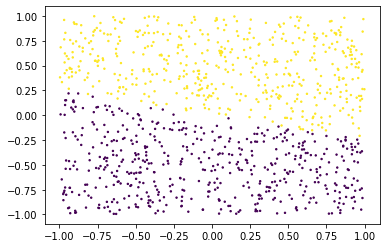

In [25]:
plt.scatter(x[:,0], x[:,1], c=y, s=2)
plt.show()

### Задача 3

In [26]:
x = np.random.uniform(-1, 1, size=(1000, 2))
labels = np.where(
    x[:, 0] > x[:, 1], 0, 
    np.where(
        (x[:, 0] < x[:, 1]) & (-x[:, 0] > x[:, 1]), 
        1, 
        2
    )
)
y = np.zeros((labels.size, labels.max() + 1))
y[np.arange(labels.size), labels] = 1

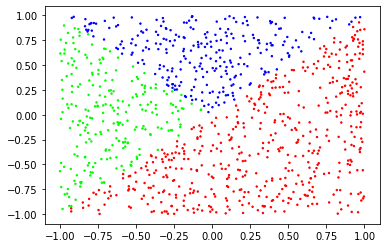

In [27]:
plt.scatter(x[:,0], x[:,1], c=y, s=2)
plt.show()